# Predominant Music Instrument Classification based on Spectral Features


We used IRMAS (Instrument recognition in Musical Audio Signals) dataset for our project. This data is polyphonic, so that  a robust classifier could be built.  Our dataset consists of .wav files of 3 seconds duration with 3,846 samples of  6 music instruments running into about three hours, giving sufficient data for training and testing purposes as well. In addition, the data consists of multiple genres including country folk, classical, pop-rock and latin soul.

In this notebook, we used Essentia, an open-source C++ based distribution package available under Python environment for feature extraction. This library computes spectral energy associated with mel bands and their MFCCs given an audio sample. We trained SVM Classifier with 10-fold Cross validation and plotted confusion matrix based on our results.

In [33]:
#pip install essentia

In [34]:
#Importing all relevant Libraries

import essentia
import pandas as pd
import numpy as np
import IPython
import os, fnmatch

import essentia.standard
import essentia.streaming
import os, fnmatch
import itertools

# Visualization
import seaborn
import matplotlib.pyplot as plt
from IPython.core.display import HTML, display
# scikit learn dependcies
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.svm import SVC
from sklearn import tree
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')


# Audio Path
path='dataset/IRMAS-TrainingData/nov-fourteen/'

In [35]:
#Total Audio Files in the directory
files = []
for root, dirnames, filenames in os.walk(path):
    for filename in fnmatch.filter(filenames, '*.wav'):
        files.append(os.path.join(root, filename))
print("found %d audio files in %s"%(len(files),path))

found 3846 audio files in dataset/IRMAS-TrainingData/nov-fourteen/


In [36]:
labels =[]
classes=['flu','pia','tru','gac','org','voi']
color_dict={'flu':'blue', 'pia':'red', 'tru':'green', 'gac':'black','org': 'yellow', 'voi':'white'}
color_list=[]
for filename in files:
    for name in classes:
        if fnmatch.fnmatchcase(filename, '*'+name+'*'):
            labels.append(name)
            color_list.append(color_dict[name])
            break
    else:
        labels.append('other')

In [37]:
#Windowing procedure is implemented in Essentia 
#It analyzes the frequency content of an audio spectrum by creating short sound segments of few milli-seconds for longer signal
#By default, we used Hann smoothing window

from essentia.standard import *

w = Windowing(type = 'hann')
spectrum = Spectrum()  # FFT() would return the complex FFT, here we just want the magnitude spectrum
mfcc = MFCC()

In [38]:
# Label Encoder for 6 Instrument classes
labelencoder = LabelEncoder()
labelencoder.fit(labels)
print(len(labelencoder.classes_), "classes:", ", ".join(list(labelencoder.classes_)))
classes_num = labelencoder.transform(labels)

6 classes: flu, gac, org, pia, tru, voi


In [ ]:
#loader
# Load files and feature vectors

feature_vectors = pd.DataFrame()

for i,f in enumerate(files):
    print ("getting %d of total %d files = %s"%(i+1, len(files), f))
    try:
        t = essentia.standard.MonoLoader(filename = f)
        y = t()
        y/=y.max() #Normalize
        if len(y) < 2:
            print("Error loading %s" % f)
            continue
        
        mfccs = []
        melbands = []
        frameSize = 1024
        hopSize = 512

        for fstart in range(0, len(y)-frameSize, hopSize):
            frame = y[fstart:fstart+frameSize]
            mfcc_bands, mfcc_coeffs = mfcc(spectrum(w(frame)))
            mfccs.append(mfcc_coeffs)
        df = pd.DataFrame(mfccs)
        #Taking average of all values (0 to 256)
        new_df = pd.DataFrame(df.mean(axis = 0)).T
        new_df['instrument'] = labels[i+1]
        feature_vectors=feature_vectors.append(new_df, ignore_index=True)
        #Add break on i if necessary (during iterations)
    except Exception as e:
        print("Error loading %s. Error: %s" % (f,e))

print("Calculated %d feature vectors"%len(feature_vectors))
    
# print(feature_vectors)

In [40]:
#Scaling features using Standard Scaler
#Operations are done only on List
scaler = StandardScaler()
scaled_feature_vectors = scaler.fit_transform(pd.DataFrame(feature_vectors.loc[:, feature_vectors.columns != 'instrument']))
print("Scaled Feature vectors shape:",scaled_feature_vectors.shape)

Scaled Feature vectors shape: (3845, 13)


In [41]:
print(scaled_feature_vectors)

[[-0.71418957  0.46260116 -0.63368777 ...  1.42038443  0.03005677
  -2.08507375]
 [-0.59754952  0.812213   -0.87790081 ... -0.82477343 -1.15354592
  -0.67547468]
 [-0.39316097  0.45744448 -0.8573588  ...  1.90472899  0.0213352
  -2.81894999]
 ...
 [ 0.55110024 -0.13087849  0.04588603 ...  0.95784067  1.38208047
  -0.03122564]
 [-1.58857567  1.86187072  1.55113236 ... -1.04412987  0.04546572
   0.58787222]
 [-0.47311193  1.4243409   0.0526503  ... -1.87433396 -0.23101698
  -0.96908015]]


In [42]:
#Appending the obtained scaled features with the class labels ('instrument')
x = pd.DataFrame(scaled_feature_vectors)
final_df = pd.concat([x,feature_vectors.instrument], axis = 1, ignore_index = True)
print("Final Dataset shape:",final_df.shape)

Final Dataset shape: (3845, 14)


In [43]:
#Check
#final_df.to_csv("check_df.csv", index = False)
print(final_df.dtypes)

0     float64
1     float64
2     float64
3     float64
4     float64
5     float64
6     float64
7     float64
8     float64
9     float64
10    float64
11    float64
12    float64
13     object
dtype: object


# Train-Test Split using StratifiedShuffleSplit

In [44]:
# Create Training and Testing Sets
testset_size = 0.25

X = final_df.iloc[:,:-1].values
Y = final_df.iloc[:,-1].values
Y_labels = labelencoder.transform(Y)

# Create Train and Test Set
splitter = StratifiedShuffleSplit(n_splits=10, test_size=testset_size, random_state=0)
splits = splitter.split(X, Y_labels)
for train_index, test_index in splits:
    train_set = X[train_index]
    test_set = X[test_index]
    train_classes = Y_labels[train_index]
    test_classes = Y_labels[test_index]

In [45]:
# Check Set Shapes
print("train_set shape:",train_set.shape)
print("test_set shape:",test_set.shape)
print("train_classes shape:",train_classes.shape)
print("test_classes shape:",test_classes.shape)

train_set shape: (2883, 13)
test_set shape: (962, 13)
train_classes shape: (2883,)
test_classes shape: (962,)


In [46]:
#Checking class ratio for each instrument in train and test
print(np.bincount(train_classes))
print(np.bincount(test_classes))

print(np.bincount(train_classes)/sum(np.bincount(train_classes)))
print(np.bincount(test_classes)/sum(np.bincount(test_classes)))

[337 478 511 541 433 583]
[113 159 171 180 144 195]
[0.11689213 0.16579951 0.17724592 0.18765175 0.15019077 0.20221991]
[0.11746362 0.16528067 0.17775468 0.18711019 0.14968815 0.2027027 ]


# SVM Classifier & Cross-Validation (10-Fold) using GridSearch

In [47]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV


def svc_param_selection(X, Y_labels, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, Y_labels)
    grid_search.best_params_
    return grid_search.best_params_

In [48]:
svc_param_selection(X, Y_labels, 10)

/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'C': 1, 'gamma': 0.1}

In [49]:
# SVM Classifier
svclassifier = SVC(kernel='rbf', C = 1, gamma=0.1)

In [50]:
#SVM
svclassifier.fit(train_set, train_classes);

In [51]:
# Predict using the test Set
predicted_labels = svclassifier.predict(train_set)

In [52]:
#Train Accuracy
print(accuracy_score(train_classes, predicted_labels))

0.7533818938605619


In [53]:
# Predict using the test Set
predicted_labels = svclassifier.predict(test_set)

In [54]:
#Test Accuracy
print(accuracy_score(test_classes, predicted_labels))

0.6496881496881497


# MODEL EVALUATION METRICS

In [55]:
pd.set_option('display.max_columns', None)

print("Recall: ", recall_score(test_classes, predicted_labels,average=None))
print("Precision: ", precision_score(test_classes, predicted_labels,average=None))
print("F1-Score: ", f1_score(test_classes, predicted_labels, average=None))
print("Accuracy: %.2f  ," % accuracy_score(test_classes, predicted_labels,normalize=True), accuracy_score(test_classes, predicted_labels,normalize=False) )

print("Number of samples:",test_classes.shape[0])

Recall:  [0.44247788 0.67295597 0.67836257 0.65       0.65972222 0.71794872]
Precision:  [0.64102564 0.62573099 0.60416667 0.72670807 0.81196581 0.57613169]
F1-Score:  [0.52356021 0.64848485 0.63911846 0.68621701 0.72796935 0.63926941]
Accuracy: 0.65  , 625
Number of samples: 962


In [56]:
#Confusion Matrix
cnf_matrix = confusion_matrix(test_classes, predicted_labels)
np.set_printoptions(precision=2)

In [57]:
# Function to Plot Confusion Matrix (from scikit learn website)
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Reds):
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# CONFUSION MATRIX & RESULTS

[[ 50   9  17  14   6  17]
 [  4 107  13  10   2  23]
 [  5  12 116   4   5  29]
 [  9  15  14 117   7  18]
 [  4   3  14  12  95  16]
 [  6  25  18   4   2 140]]


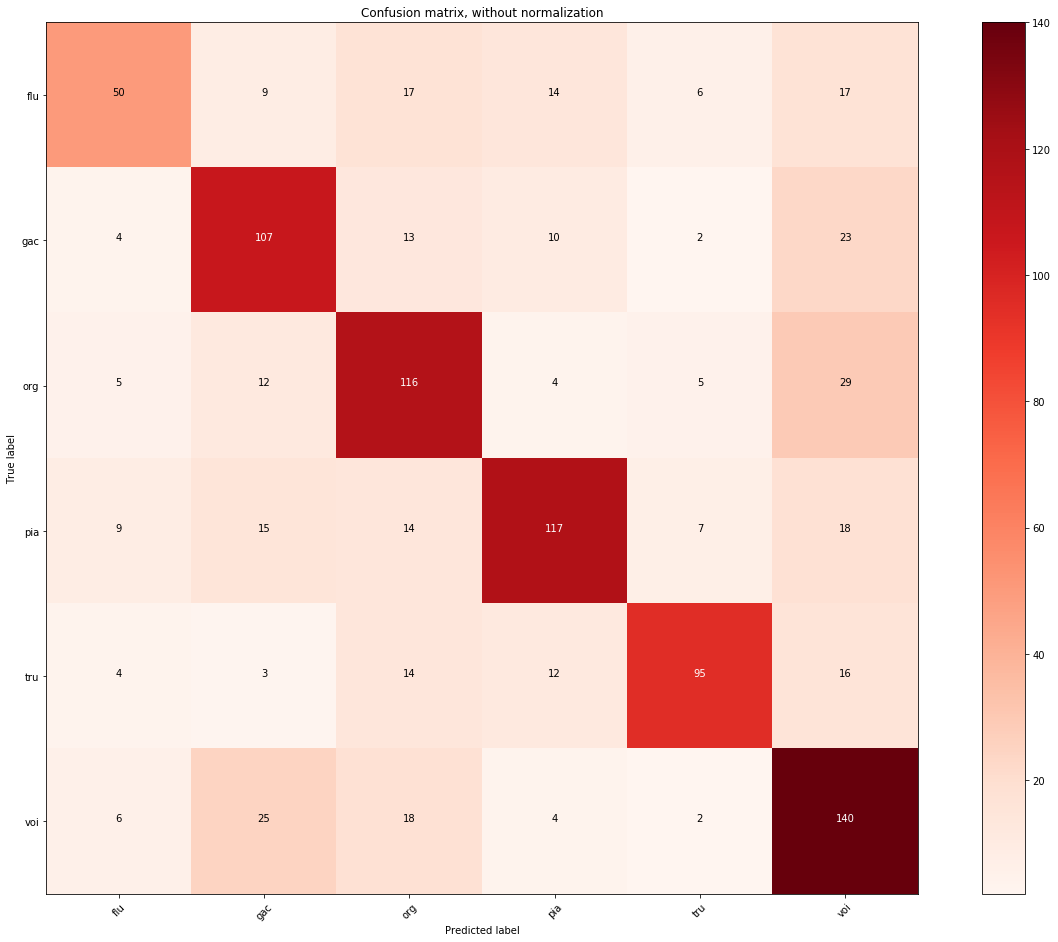

In [58]:
# Plotting non-normalized confusion matrix
%matplotlib inline
plt.figure(figsize=(18,13))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')
plt.savefig("Charts.pdf")

In [59]:
# Finding wrongly predicted samples
wrong_predictions = [i for i, (e1, e2) in enumerate(zip(predicted_labels,test_classes)) if e1 != e2]

In [77]:
# Find wrong predicted audio files
print("True labels")
print(np.array(labels)[test_index[wrong_predictions]])
print("Predicted labels")
print(labelencoder.inverse_transform(predicted_labels[wrong_predictions]))

True labels
['tru' 'pia' 'voi' 'flu' 'pia' 'pia' 'voi' 'org' 'flu' 'flu' 'pia' 'flu'
 'flu' 'gac' 'tru' 'pia' 'flu' 'tru' 'pia' 'tru' 'tru' 'org' 'pia' 'voi'
 'org' 'pia' 'tru' 'pia' 'org' 'flu' 'org' 'gac' 'gac' 'voi' 'gac' 'pia'
 'org' 'org' 'voi' 'flu' 'org' 'voi' 'gac' 'voi' 'gac' 'voi' 'org' 'pia'
 'org' 'voi' 'voi' 'org' 'flu' 'flu' 'tru' 'voi' 'gac' 'pia' 'org' 'flu'
 'tru' 'gac' 'gac' 'flu' 'tru' 'tru' 'org' 'flu' 'org' 'flu' 'flu' 'gac'
 'gac' 'voi' 'gac' 'gac' 'pia' 'pia' 'flu' 'pia' 'tru' 'org' 'flu' 'pia'
 'voi' 'org' 'voi' 'pia' 'pia' 'pia' 'org' 'voi' 'org' 'gac' 'gac' 'tru'
 'org' 'gac' 'org' 'gac' 'voi' 'gac' 'flu' 'pia' 'flu' 'org' 'flu' 'flu'
 'gac' 'voi' 'flu' 'pia' 'pia' 'voi' 'pia' 'flu' 'flu' 'pia' 'tru' 'voi'
 'flu' 'tru' 'org' 'tru' 'pia' 'org' 'pia' 'gac' 'flu' 'org' 'flu' 'voi'
 'org' 'pia' 'flu' 'org' 'tru' 'pia' 'voi' 'flu' 'voi' 'flu' 'pia' 'gac'
 'pia' 'voi' 'voi' 'org' 'tru' 'voi' 'gac' 'voi' 'pia' 'tru' 'voi' 'flu'
 'gac' 'voi' 'org' 'flu' 'org' 'gac' 't